In [1]:
# 1. Imports and Data loading
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Generate synthetic data with noise
X, y_true = make_moons(n_samples=300, noise=0.1, random_state=42)
X = np.vstack([X, np.random.uniform(low=-1.5, high=2.5, size=(30, 2))])  # Add noise points
y_true = np.hstack([y_true, -np.ones(30)])  # -1 indicates noise in ground truth

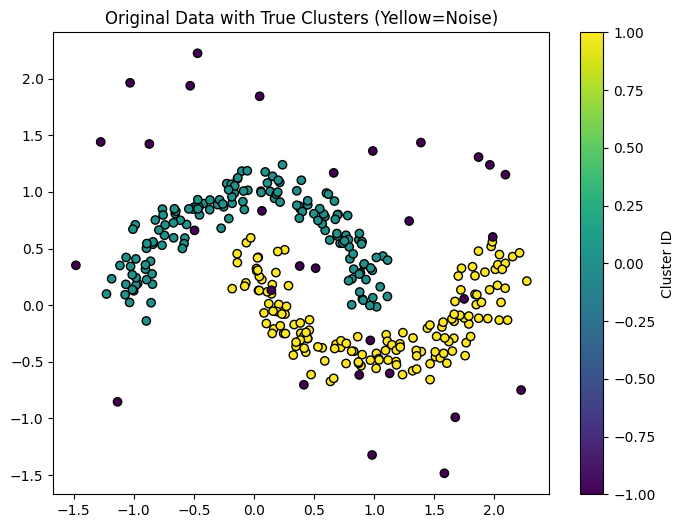

In [2]:
# 2. Data Visualization
# Show original data distribution with artificial noise

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='viridis', edgecolors='k')
plt.title("Original Data with True Clusters (Yellow=Noise)")
plt.colorbar(label="Cluster ID")
plt.show()

In [3]:
# 3. Data Preprocessing
# Scale features for density-based clustering

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# 4. Parameter Sensitivity Analysis
# Test different eps and min_samples values

eps_values = np.linspace(0.1, 0.5, 10)
min_samples_values = [3, 5, 7]
results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
        n_clusters = len(np.unique(db.labels_[db.labels_ != -1]))  # Ignore noise
        noise_ratio = np.sum(db.labels_ == -1)/len(X)

        if n_clusters > 0:  # Only calculate metrics if clusters exist
            sil_score = silhouette_score(X_scaled, db.labels_)
        else:
            sil_score = -1

        results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'noise_ratio': noise_ratio,
            'silhouette': sil_score
        })

results_df = pd.DataFrame(results)

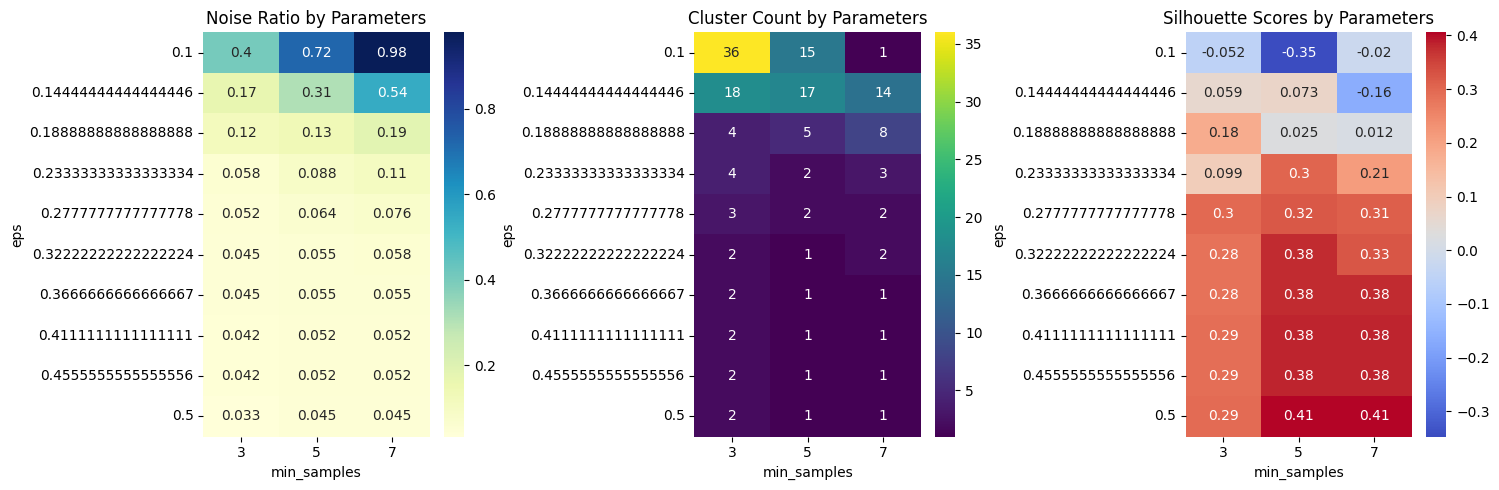

In [5]:
# 5. Parameter Effects Visualization
# Analyze cluster formation patterns

plt.figure(figsize=(15, 5))

# Noise ratio heatmap
plt.subplot(1, 3, 1)
heatmap_data = results_df.pivot(
    index="eps",
    columns="min_samples",
    values="noise_ratio"
)
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu")
plt.title("Noise Ratio by Parameters")

# Cluster count heatmap
plt.subplot(1, 3, 2)
heatmap_data = results_df.pivot(
    index="eps",
    columns="min_samples",
    values="n_clusters"
)
sns.heatmap(heatmap_data, annot=True, cmap="viridis")
plt.title("Cluster Count by Parameters")

# Silhouette score heatmap
plt.subplot(1, 3, 3)
heatmap_data = results_df.pivot(
    index="eps",
    columns="min_samples",
    values="silhouette"
)
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm")
plt.title("Silhouette Scores by Parameters")

plt.tight_layout()
plt.show()

In [6]:
# 6. Final Model Training
# Select optimal parameters from analysis

best_params = results_df.loc[results_df['silhouette'].idxmax()]
print("Selected parameters:\n", best_params)

final_dbscan = DBSCAN(
    eps=best_params['eps'],
    min_samples=int(best_params['min_samples'])
).fit(X_scaled)

Selected parameters:
 eps            0.500000
min_samples    5.000000
n_clusters     1.000000
noise_ratio    0.045455
silhouette     0.405660
Name: 28, dtype: float64


Silhouette Score: 0.406
Adjusted Rand Index: 0.114
Noise Points Identified: 15/30


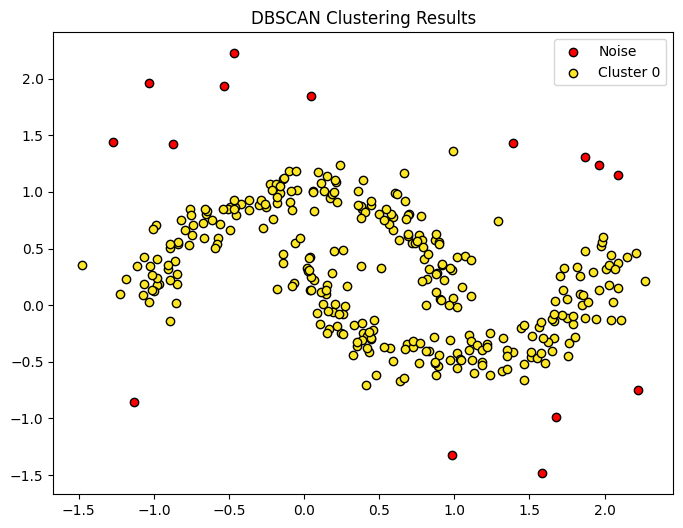

In [7]:
# 7. Results Evaluation
# Compare with ground truth and visualize clusters

# Calculate metrics
sil_score = silhouette_score(X_scaled, final_dbscan.labels_)
ari_score = adjusted_rand_score(y_true, final_dbscan.labels_)
noise_points = np.sum(final_dbscan.labels_ == -1)

print(f"Silhouette Score: {sil_score:.3f}")
print(f"Adjusted Rand Index: {ari_score:.3f}")
print(f"Noise Points Identified: {noise_points}/{len(y_true[y_true == -1])}")

# Visualization
plt.figure(figsize=(8, 6))
unique_labels = np.unique(final_dbscan.labels_)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        color = 'red'  # Highlight noise

    mask = final_dbscan.labels_ == label
    plt.scatter(X[mask, 0], X[mask, 1],
                c=[color],
                edgecolors='k',
                label=f'Cluster {label}' if label != -1 else 'Noise')

plt.title("DBSCAN Clustering Results")
plt.legend()
plt.show()